In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import os
import time
import zipfile
import shutil
import PIL
import opendatasets as od
from torchinfo import summary

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset

In [34]:
# kaggle에서 데이터 받기
dataset_url = 'https://www.kaggle.com/c/dogs-vs-cats/data'
od.download(dataset_url)

Skipping, found downloaded files in ".\dogs-vs-cats" (use force=True to force download)


In [2]:
data_zip_dir = 'dogs-vs-cats'
train_zip_dir = os.path.join(data_zip_dir, 'train1.zip')
#test_zip_dir = os.path.join(data_zip_dir, 'test1.zip')

with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall(path = data_zip_dir)
#with zipfile.ZipFile(test_zip_dir, 'r') as z:
#    z.extractall(path = data_zip_dir)

In [3]:
train_dir = os.path.join(data_zip_dir, 'train1')
#test_dir = os.path.join(data_zip_dir, 'test1')

train_set_dir = os.path.join(data_zip_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(data_zip_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(data_zip_dir, 'test')
os.mkdir(test_set_dir)

In [4]:
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst) 
    
for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)

In [5]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validation set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validation set : 2500
the number of test set : 2500


In [6]:
# torch.utils.data.Dataset을 사용하여 custom dataset 만들기
# 참고: https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html

# 레이블을 지정하는 경우 자주 사용하게 될 듯
class CustomDataset(Dataset):
    '''
    __init__(self, files, root, mode='train', transform=None) : 클래스를 생성할 때 실행되는 생성자
        ㄴfiles : 이미지 파일 이름을 저장하고 있는 list
        ㄴroot : 이미지 파일이 존재하는 폴더 경로
        ㄴmode : 해당 dataset이 학습용인지 평가용인지 체크
        ㄴtransform : 이미지의 전처리를 위한 torchvision.transform
    '''    
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform = transform
        
        # 이미지 파일의 이름에 'cat'이 포함되어 있을 경우
        if 'cat' in files[0]:
            # 고양이 이미지 레이블 - 0
            self.label = 0
        else:
            # 강아지 이미지 레이블 - 1
            self.label = 1
            
    '''
    __len__(self) : Dataset의 길이를 반환하기 위한 메소드
    '''              
    def __len__(self):
        return len(self.files)
    
    '''
    __getitem__(self, index) : 클래스의 인덱스에 접근할 때 자동으로 호출되는 메소드
                               주어진 key에 해당하는 data를 반환하며,
                               key에 해당하는 이미지 파일을 읽고, 전처리 과정을 통해서 data를 리턴합니다. 
                               mode='train'일 경우에는 label을 반환하고, 'train'용이 아닌 경우에는 label을 모르기 때문에 
                               실제 이미지 파일의 경로를 반환하도록 합니다.
    '''        
    def __getitem__(self, index):
        # 이미지 불러오기(경로, 인덱스)
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        # 이미지 전처리
        if self.transform:
            img = self.transform(img)
        # 학습 이미지 리턴 (이미지, 레이블)
        if self.mode == 'train':
            return img, np.array([self.label])
        # 테스트 이미지 리턴
        else:
            return img, self.files[index]        

In [7]:
# 이미지 전처리
train_transform = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.RandomCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])

In [8]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)

valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)

test_dog_dataset = CustomDataset(dog_files[11250:12500], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:12500], test_set_dir, transform=test_transform)

# 학습 데이터셋 concat: dog - [:10000],  cat - [10000:20000]
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [9]:
train_dataset[0], train_dataset[0][0].shape

((tensor([[[0.6824, 0.6784, 0.6745,  ..., 0.7176, 0.7098, 0.7216],
           [0.6706, 0.6667, 0.6667,  ..., 0.7137, 0.7137, 0.7176],
           [0.6471, 0.6471, 0.6471,  ..., 0.7176, 0.7059, 0.7137],
           ...,
           [0.4745, 0.5059, 0.4745,  ..., 0.8353, 0.8314, 0.8392],
           [0.6196, 0.5216, 0.3765,  ..., 0.8196, 0.8118, 0.8157],
           [0.5137, 0.3922, 0.3020,  ..., 0.7804, 0.7647, 0.7294]],
  
          [[0.6824, 0.6824, 0.6784,  ..., 0.7333, 0.7294, 0.7333],
           [0.6667, 0.6706, 0.6706,  ..., 0.7333, 0.7333, 0.7294],
           [0.6471, 0.6510, 0.6510,  ..., 0.7373, 0.7255, 0.7255],
           ...,
           [0.4275, 0.4667, 0.4431,  ..., 0.6980, 0.6980, 0.6863],
           [0.5529, 0.4863, 0.3529,  ..., 0.7020, 0.6980, 0.6863],
           [0.4627, 0.3686, 0.2941,  ..., 0.6980, 0.6863, 0.6392]],
  
          [[0.6941, 0.6980, 0.6980,  ..., 0.7804, 0.7725, 0.7608],
           [0.6784, 0.6863, 0.6902,  ..., 0.7765, 0.7804, 0.7608],
           [0.6588, 0.

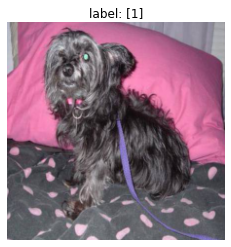

In [10]:
image = train_dataset[0][0].permute(1, 2, 0)
label = train_dataset[0][1]

plt.imshow(image)
plt.axis('off')
plt.title(f'label: {label}')
plt.show()

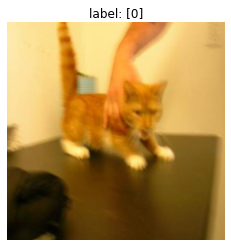

In [11]:
image = train_dataset[10000][0].permute(1, 2, 0)
label = train_dataset[10000][1]

plt.imshow(image)
plt.axis('off')
plt.title(f'label: {label}')
plt.show()

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

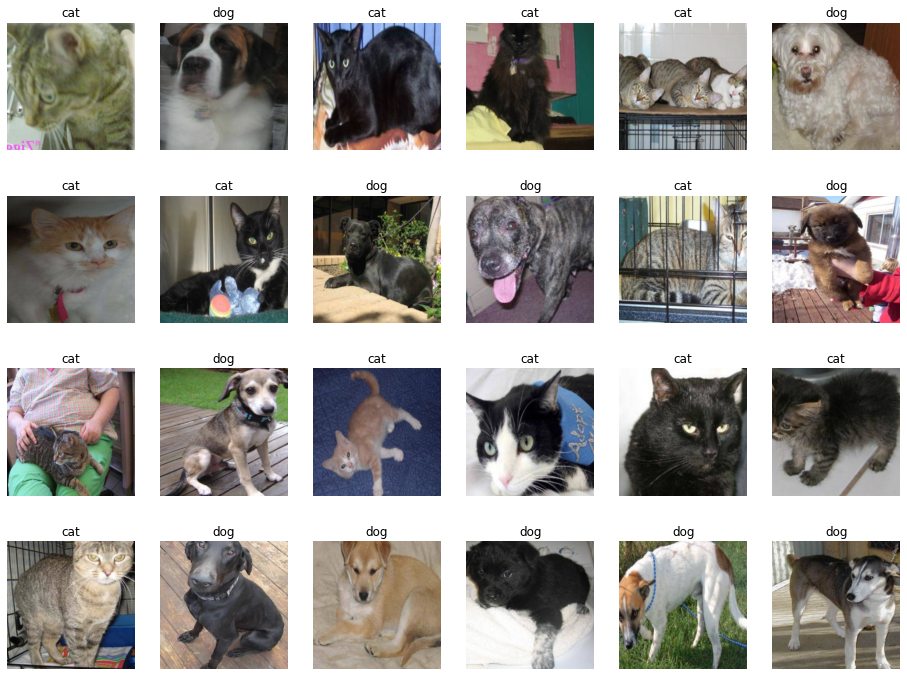

In [14]:
samples, labels = next(iter(train_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16, 24))

for i in range(24):
    # add_subplot(col, row, idx): 한 화면에 여러개 그리기
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
    
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

----------------------------------------------------------------------------------------------------------------------------------------

## VGG model architecture

![vgg19](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbw2WnC%2FbtqKSgFqB3D%2FhYW6yfkjGFXmzMMwEM7tZ1%2Fimg.png)

![vgg19_3](https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png)

VGGNet 은 2014년 ILSVRC에서 GoogLeNet 과 함께 주목을 받았고 간소한 차이로 2위를 차지한 모델이다. VGGNet의 목적은 network의 depth가 어떤 영향을 주는지 연구하기 위함이었다. 그래서 convolution filter 를 하나의 크기로 고정하여 layer를 늘려나가는 방식으로 테스트를 진행한다.

In [15]:
cfgs = { "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
         "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
         "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
         "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"] }

In [16]:
class VGG(nn.Module):
    def __init__(self, cfg, batch_norm, num_classes = 1000, init_weights = True, dropout = 0.5):
        super().__init__()
        
        self.features = self.make_layers(cfg, batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                       nn.ReLU(),
                                       nn.Linear(4096, 4096),
                                       nn.ReLU(),
                                       nn.Dropout(p=dropout),
                                       nn.Linear(4096, num_classes))
        
        if init_weights:
            # self.modules() -> 모델 클래스에서 정의된 layer들을 iterable로 차례로 반환
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        # torch.nn.init.constant_(tensor, val)
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    # torch.nn.init.normal_(tensor, mean=0.0, std=0.01)
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out
    
    def make_layers(self, cfg, batch_norm = False):
        layers = []
        in_channels = 3
        for v in cfg:
            if type(v) == int:
                if batch_norm:
                    layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                              nn.BatchNorm2d(v),
                              nn.ReLU()]
                else:
                    layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                              nn.ReLU()]
                in_channels = v
            else:
                layers += [nn.MaxPool2d(2)]
        return nn.Sequential(*layers)

In [17]:
model = VGG(cfgs["E"], batch_norm=False)
summary(model, input_size=(2, 3, 224, 224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1000]                 --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [2, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [2, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [2, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [2, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [2, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [2, 256, 56, 56]          29

In [18]:
x = torch.randn(2, 3, 224, 224)
print(model(x).shape)

torch.Size([2, 1000])


----------------------------------------------------------------------------------------------------------------------------------------

## Using pretrained model: VGG19

In [19]:
model_vgg19 = torchvision.models.vgg19(pretrained=True)
model_vgg19

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [20]:
input_features_fc_layer = model_vgg19.classifier[0].in_features

model_vgg19.classifier = nn.Sequential(
    nn.BatchNorm1d(input_features_fc_layer),
    nn.Linear(input_features_fc_layer, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [21]:
model_vgg19.to(device)
summary(model_vgg19, input_size=(2, 3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1]                    --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [2, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [2, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [2, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [2, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [2, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [2, 256, 56, 56]          29

In [22]:
def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()
    
    train_loss = 0
    train_acc = 0
    train_correct = 0
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()
        
        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()
        
        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)
        
        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)
        
        train_loss = 0
        train_acc = 0
        train_correct = 0
    
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()
    plt.title('accuracy')
    plt.show()

In [23]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_vgg19.parameters(), lr=1e-5)

248.768sec : [Epoch 1/10] -> train loss: 0.1439, train acc: 96.055% / valid loss: 0.0610, valid acc: 98.520%
166.671sec : [Epoch 2/10] -> train loss: 0.0463, train acc: 98.980% / valid loss: 0.0451, valid acc: 98.600%
167.113sec : [Epoch 3/10] -> train loss: 0.0302, train acc: 99.240% / valid loss: 0.0382, valid acc: 98.800%
161.871sec : [Epoch 4/10] -> train loss: 0.0229, train acc: 99.470% / valid loss: 0.0373, valid acc: 98.760%
161.211sec : [Epoch 5/10] -> train loss: 0.0174, train acc: 99.630% / valid loss: 0.0364, valid acc: 98.840%
160.626sec : [Epoch 6/10] -> train loss: 0.0136, train acc: 99.765% / valid loss: 0.0375, valid acc: 98.840%
159.874sec : [Epoch 7/10] -> train loss: 0.0109, train acc: 99.840% / valid loss: 0.0368, valid acc: 98.920%
158.267sec : [Epoch 8/10] -> train loss: 0.0086, train acc: 99.865% / valid loss: 0.0353, valid acc: 98.680%
158.830sec : [Epoch 9/10] -> train loss: 0.0064, train acc: 99.945% / valid loss: 0.0392, valid acc: 98.680%
158.825sec : [Epoch

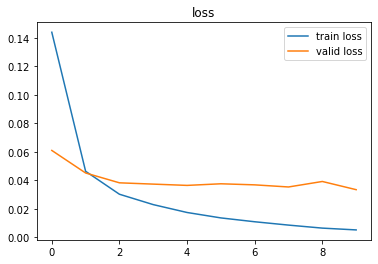

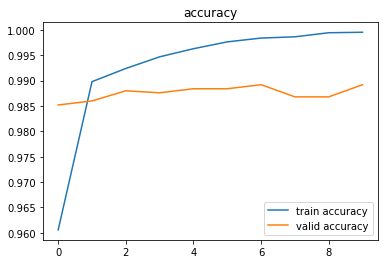

In [24]:
fit(model_vgg19, criterion, optimizer, 10, train_loader, valid_loader)

In [25]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            
            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [26]:
eval(model_vgg19, criterion, test_loader)

eval loss: 0.0220, eval acc: 99.440%


In [27]:
test_dir = 'dogs-vs-cats/test1'
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=128, shuffle=False)

In [28]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)
            
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret
   
pred = predict(model_vgg19, submit_loader)

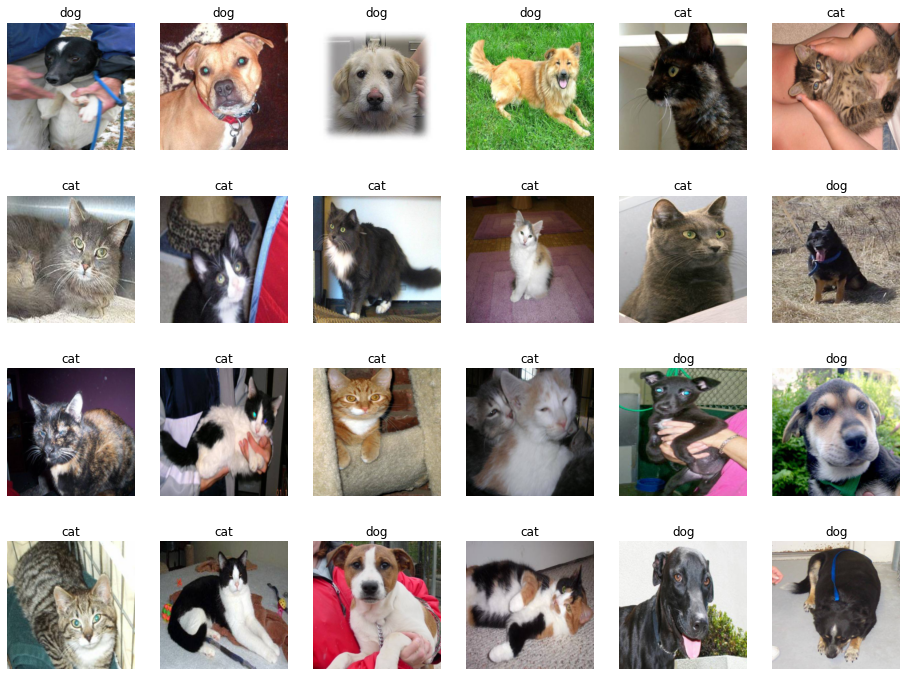

In [30]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0
 
imgs, files = next(iter(submit_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]])
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)